# Exploring Order Dependency in LLMs

While LLMs have demonstrated remarkable capabilities in understanding and generating text, they also exhibit a number of unexpected behavioral patterns. Hallucinations are one well known example, but there are others that are less obvious and more subtle.

In this experiment, we'll explore the *order dependency problem*: a language models' sensitivity to the order of tokens in a sequence. Multiple researchers have shown that small changes to the order that information is presented to a model can make a large difference in the model's response. Like hallucinations, order dependency is a significant obstacle to user acceptance and broader adoption of AI solutions. This is because order dependency leads to inconsistent model outputs, making models seem unreliable and eroding users' trust. For AI solutions to deliver on their promises, they need to be more robust. We can't accept healthcare models that change a diagnosis based on the order a patient's labs are entered. Or financial models that approve or deny loan applications based on who is first or last in line.

One specific area where order dependency has been thoroughly studied is in answering multiple choice questions (MCQs). MCQs are widely used as benchmarks to evaluate LLMs' language understanding and reasoning capabilities. However, multiple researchers have independently shown that simply changing the order the choices are presented can dramatically change a model's score. They've also demonstrated this behavior isn't limited to one or two models, but is a general pattern exhibited by the decoder-only Transformer architectures that dominate the current landscape.

We'll spend the rest of this experiment exploring the order dependency problem from multiple viewpoints. First, we'll demonstrate the problem on a tiny sample of MCQs. Next, we'll step back and evaluate the extent of the problem. Finally, we'll take a closer look at the leading hypotheses on the potential causes behind order dependency.

# Parameters

In [1]:
# Sample size
n_questions = 256

# Number of test runs
n_runs = 10

# Setup

In [2]:
#-------------------------------------------------------------------------------
# Imports
#-------------------------------------------------------------------------------

import base64
from collections import Counter
import logging
from functools import partial
from io import BytesIO
import os
from pathlib import Path
from random import sample
import re
from time import perf_counter_ns as timer

from IPython.display import display, HTML, Markdown
from matplotlib import pyplot as plt
from pandas import DataFrame
import seaborn as sns
from tqdm import tqdm

import llama_benchmarks as llb
from llama_benchmarks.models import llama
from llama_benchmarks.mmlu import Question, Questions, Answer, Answers, MMLULlamaGenerator, OPTIONS

In [3]:
#-------------------------------------------------------------------------------
# Configure Experiment
#-------------------------------------------------------------------------------

# Switch to project root
if os.path.basename(os.getcwd()) == "experiments":
    os.chdir("..")

# Configure logger
logger = logging.getLogger(__name__)

# Path to datasets
datasets_path = Path(".build") / "datasets"

In [4]:
%%html
<style>
table.questions {
    width:100%;
}
table.questions td, table.questions th {
    text-align: left !important;
}
table.questions tfoot td {
    text-align: right !important;
}
</style>

In [5]:
#-------------------------------------------------------------------------------
# Utility Functions
#-------------------------------------------------------------------------------

def show_questions(questions: Questions):
    """Render questions as a table."""

    max_rows = 5
    rows = ""
    for i in range(min(len(questions), max_rows)):
        q = questions[i]
        rows += f"<tr><td>{q.qid}</td><td>{q.category}</td><td>{q.question}</td><td>{q.A}</td><td>{q.B}</td><td>{q.C}</td><td>{q.D}</td><td>{q.answer}</td></tr>"
    
    display(HTML(        
        f"""
        <table class="questions">
        <tr><th>QID</th><th>Category</th><th>Question</th><th>A</th><th>B</th><th>C</th><th>D</th><th>Answer</th></tr>
        {rows}
        </table>
        """
    ))    


def remove_referentials(questions: Questions) -> Questions:
    """Discard questions with options that refer to other options, e.g. A or B."""
    word_pattern = re.compile(r"\b\w+\b")

    results = []
    for q in questions:
        # Look for options that refer to other options, e.g. A, B, A or B
        referential_options = []
        for option in OPTIONS:
            option_value = getattr(q, option)
            
            # Break option_value into words
            words = re.findall(word_pattern, option_value)
    
            # Look for references to options A, B, C, D
            if any(o in words for o in OPTIONS):
                referential_options.append(option)
                continue

            # Look for "of the above" as in None of the above, All of the above, etc
            if "of the above" in option_value:
                referential_options.append(option)
                continue

        # If q does not have self-referential options, keep it
        if not referential_options:
            results.append(q)

    print(f"Discarded {len(questions) - len(results)} questions")

    return tuple(results)


def render_scores(answer: Answer):
    """Render scores for each option as a bar chart."""
    # Plot scores
    fig, ax = plt.subplots()

    default_color = "#1f77b4"
    correct_color = "#2ca02c"
    incorrect_color = "#d62728"
    answer_color = correct_color if answer.correct else incorrect_color
    
    colors = [answer_color if k == answer.actual else default_color for k in answer.scores]
    plt.bar(OPTIONS, [answer.scores[k] for k in OPTIONS], color=colors)

    # Save to png
    buffer = BytesIO()
    fig.savefig(buffer, format="png", bbox_inches="tight")
    plt.close(fig)
    buffer.seek(0)

    # Package png as html snippet
    content = base64.b64encode(buffer.read()).decode("utf-8")
    html = f"<img src=\"data:image/png;base64,{content}\">"
    
    return html

    
def example_question_report(qid: int):
    """Display summary report of question."""
    
    # Look up question
    question = next(q for q in questions if q.qid == qid)

    # A
    q = llb.mmlu.swap_answers([question], "A")[0]
    a = next(generator([q]))
    content_a = (llb.mmlu.generate_prompt(q) + a.actual).replace("\n", "<br>")
    scores_a = render_scores(a)
    
    # B
    q = llb.mmlu.swap_answers([question], "B")[0]
    a = next(generator([q]))
    content_b = (llb.mmlu.generate_prompt(q) + a.actual).replace("\n", "<br>")
    scores_b = render_scores(a)

    # C
    q = llb.mmlu.swap_answers([question], "C")[0]
    a = next(generator([q]))
    content_c = (llb.mmlu.generate_prompt(q) + a.actual).replace("\n", "<br>")
    scores_c = render_scores(a)

    # D
    q = llb.mmlu.swap_answers([question], "D")[0]
    a = next(generator([q]))
    content_d = (llb.mmlu.generate_prompt(q) + a.actual).replace("\n", "<br>")
    scores_d = render_scores(a)

    display(HTML(
        f"""
        <table class="questions">
        <tr><th>Scenario A</th><th>Scenario B</th><th>Scenario C</th><th>Scenario D</th></tr>        
        <tr><td>{content_a}</td><td>{content_b}</td><td>{content_c}</td><td>{content_d}</td></tr>
        <tr><td>{scores_a}</td><td>{scores_b}</td><td>{scores_c}</td><td>{scores_d}</td></tr>
        <tfoot>
            <tr><td colspan="4"><b>qid=</b>{qid}, <b>category=</b>"{question.category}"</td></tr>
        </tfoot>
        </table>
        """
    ))

# Related Work

The ideas and concepts presented here lean heavily on three research papers published over the past 2 years. Pezeshkpour and Hruschka (2023) studied order dependency in GPT4 (OpenAI et al. 2024) and InstructGPT (Ouyang et al. 2022) and hypothesized the issue was caused by a mixture of uncertainty and *positional bias*. Zheng et al. (2024) studied order dependency in 20 LLMs from 4 popular families and suggested the issue was actually due to *token bias* instead of positional bias. Finally, McIlroy-Young et al. (2024) built on the ideas from the first two papers and recommended a general Set-Based Prompting solution.

# MMLU Dataset

First off, we need a source of MCQs. We'll use the standard benchmark Massive Multitask Language Understanding (MMLU) (Hendrycks et al. 2021) dataset. MMLU contains 14,042 MCQs from 57 categories. Each question has 4 options A, B, C, and D and one correct answer. In addition, each category has 5 example questions designed for few-shot experiments. MMLU can be downloaded from https://github.com/hendrycks/test.

In [6]:
# Path to downloaded dataset
mmlu_dataset_path = datasets_path / "mmlu"

# Load all questions from MMLU
questions = llb.mmlu.load_dataset(mmlu_dataset_path)
show_questions(questions[0:3])

QID,Category,Question,A,B,C,D,Answer
0,abstract algebra,"Find the degree for the given field extension Q(sqrt(2), sqrt(3), sqrt(18)) over Q.",0,4,2,6,B
1,abstract algebra,"Let p = (1, 2, 5, 4)(2, 3) in S_5 . Find the index of in S_5.",8,2,24,120,C
2,abstract algebra,Find all zeros in the indicated finite field of the given polynomial with coefficients in that field. x^5 + 3x^3 + x^2 + 2x in Z_5,0,1,"0,1","0,4",D


In [7]:
print(f"Loaded {len(questions)} questions in {len({q.category for q in questions})} categories.")

Loaded 14042 questions in 57 categories.


## Data Cleaning

### Referential Options

Before we move on to the LLMs, we need to clean up the MMLU data a bit. The first issue we'll tackle are questions with options that refer to other options. For example, consider question 253:

In [8]:
print(llb.mmlu.generate_prompt(next(q for q in questions if q.qid == 253), n_shots=0, header=False))

Question: Which of the following is/are common feature(s) of all fresh (i.e. not eroded) impact craters formed on solid surfaces:

A) ejecta
B) raised rims
C) central peaks
D) A and B only

Answer: 


Note that option D refers to options A and B. As soon as we start moving options around, option D becomes nonsensical. To avoid this situation, we discard any question with options that refer to other options.

In [9]:
questions = remove_referentials(questions)

print(f"Kept {len(questions)} questions from {len({q.category for q in questions})} categories.")

Discarded 1079 questions
Kept 12963 questions from 57 categories.


In [10]:
# Sanity checks

# There should be at least 10k questions
assert len(questions) > 10000

# qids should be unique
assert len({q.qid for q in questions}) == len(questions)

### Answer Distribution

The next issue we'll tackle is bias caused by non-uniform answer distribution. Our goal is to highlight the selection bias inherent to the model. This means we can't give the model any reason to favor one option over another. However, the answers in MMLU are not evenly distributed. To control for this, we'll evenly distribute the answers across the 4 options A, B, C, D.

Below is a demonstration of the function `llb.mmlu.debias_question_answers`. We'll apply this after taking each random sample later on in the experiment. 

In [11]:
# Record initial answer distribution
example_distribution1 = llb.mmlu.answer_distribution(questions)

# Debias examples
debiased = llb.mmlu.debias_question_answers(questions)

# Record debiased answer distribution
example_distribution2 = llb.mmlu.answer_distribution(debiased)

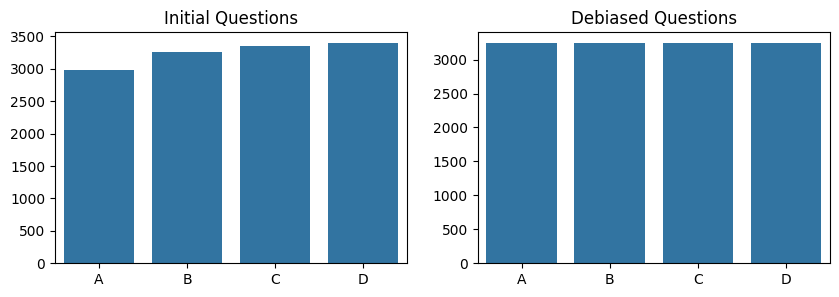

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(10,3))

sns.barplot(example_distribution1, ax=axs[0])
axs[0].set_title("Initial Questions")

sns.barplot(example_distribution2, ax=axs[1])
axs[1].set_title("Debiased Questions")

fig.subplots_adjust(hspace=0.3)

# Llama Models

We'll focus our experiment on the Llama 3.2 3B LLM. Llama 3.2 3B is a state-of-the-art LLM from Meta that is ideal for local experiments because it's open source and fits on smaller systems with a single GPU. For more details, check out [the Llama 3.2 model card on GitHub](https://github.com/meta-llama/llama-models/blob/main/models/llama3_2/MODEL_CARD.md).

To quantify the model's accuracy, we'll follow the same MCQ evaluation protocol used by Zheng et al. (2024) and others. We create zero-shot prompts and answer them using a Llama LLM. Instead of trying to parse the answer from the model's output stream, we extract the logits for tokens "A", "B", "C", "D" from the model's output layer and convert them to probabilities. We're effectively limiting the model's output vocabulary to the 4 options. Not only does this let us quickly identify the model's "answer", it also gives us a direct representation of the model's uncertainty.

In [13]:
# Show prompt example
print(llb.mmlu.generate_prompt(sample(questions, 1)[0]))

Question: Which of the following is true of appellate courts?

A) Appellate judges never use the stare decisis principle.
B) Appellate trials are usually jury trials.
C) Appellate judges usually decide the facts of a case.
D) Appellate judges review decisions of lower courts.

Answer: 


To make the analysis easier, we use a custom generator `llama_benchmarks.mmlu.MMLULlamaGenerator` that provides an custom interface for answering MMLU questions, uses a custom head stage to extracts logits for "A", "B", "C", "D", and avoids all token sampling. This streamlined generator scaffolding is wrapped around the off-the-shelf Llama 3.2 3B model downloaded from Meta (https://www.llama.com/).

In [14]:
config = llama.config("Llama3.2-3B")
config._asdict()

{'device': device(type='mps'),
 'checkpoint_path': PosixPath('/Users/andrewyoung/.llama/checkpoints/Llama3.2-3B'),
 'vocab_size': 128256,
 'd_model': 3072,
 'd_head': 128,
 'd_ffn': 8192,
 'n_layers': 28,
 'n_heads': 24,
 'n_kv_heads': 8,
 'rms_norm_eps': 1e-05,
 'rope_theta': 500000.0,
 'max_seq_len': 8192,
 'temperature': 0.6,
 'top_k': 50,
 'top_p': 0.9,
 'max_completion_tokens': 64}

In [15]:
generator = MMLULlamaGenerator(config)

# Examples of Order Dependency

Let's take a look at a few hand curated examples. We ask the model to answer 4 versions of each question. In the first version, we move the correct answer to option A. In the second version, the correct answer is in option B, etc. For each version, we show the prompt, the model's answer and plot the model's confidence in each option.

## Question: What country was once ruled by shoguns?

This is an easy one to start. You can see that the model gets it right every time. Furthermore, the charts below show that the model remains confident about the answer no matter where we move it. This is a good example of what we *want* to see.


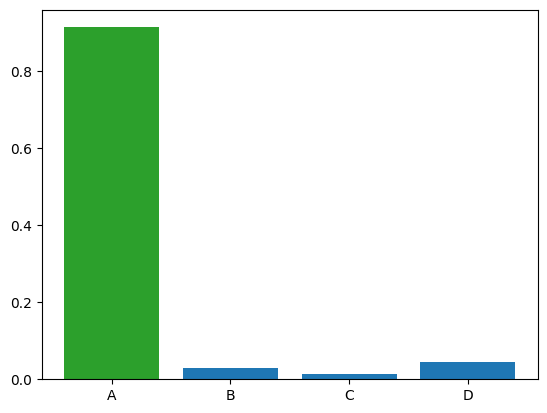
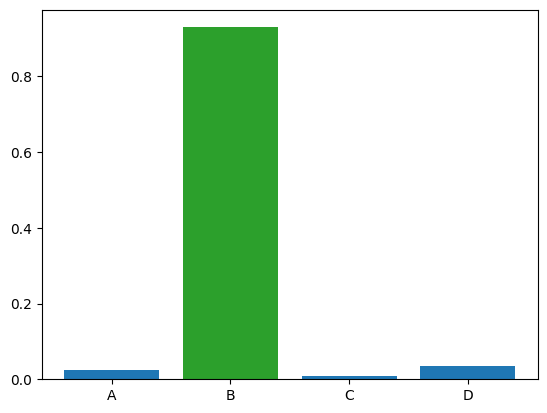
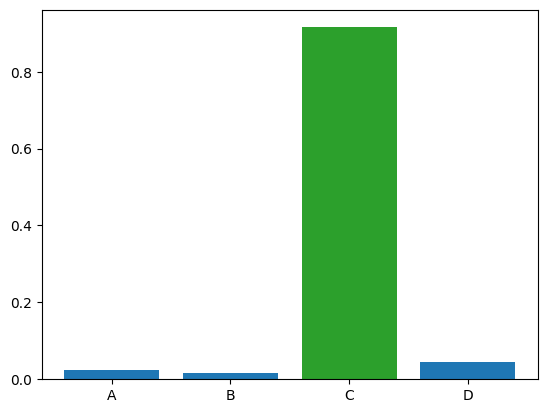
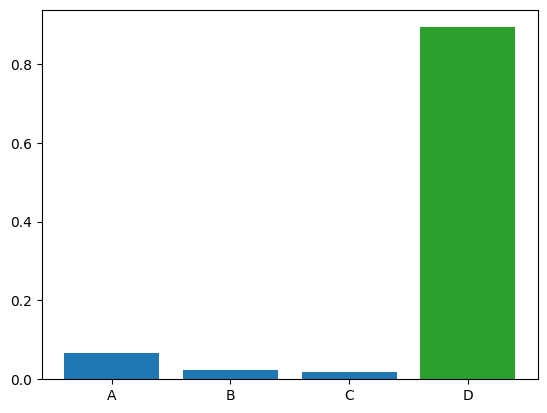

In [16]:
example_question_report(7779)

## Question: What was Richard Nixon's middle name?

In this case, the model appears a lot less certain. What's interesting is even though the only difference between the scenarios is the option ordering, the model's confidence varies quite a bit.


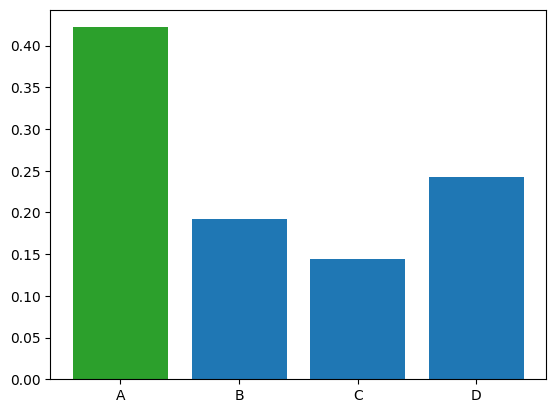
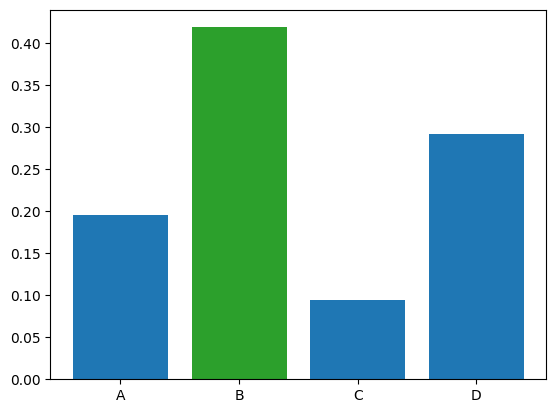
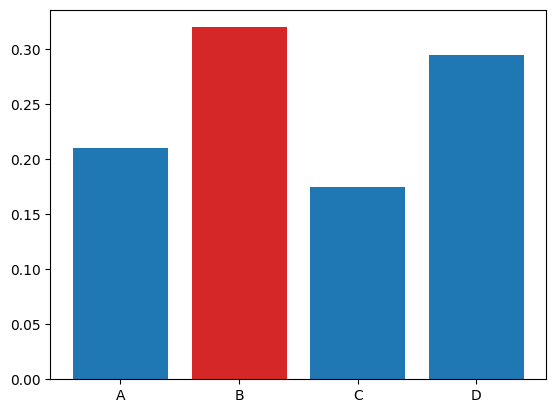
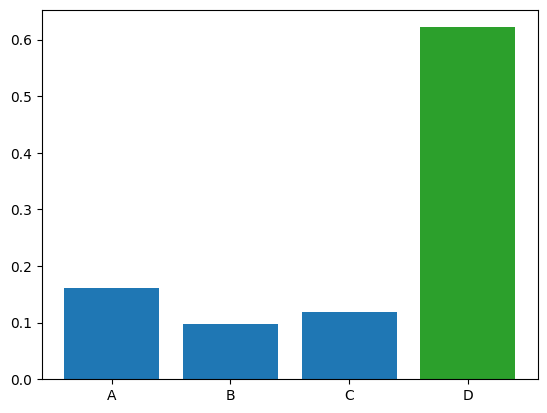

In [17]:
example_question_report(7469)

## Question: When was the current Dalai Lama born?

In this case it almost looks like the lower we place the answer (1935), the less confident the model becomes.


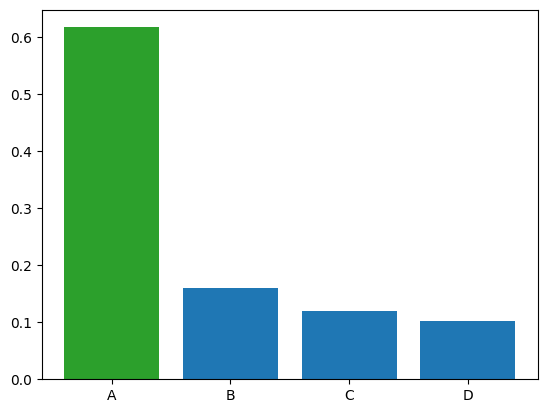
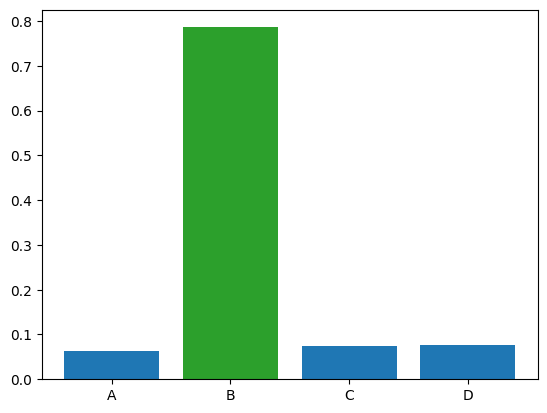
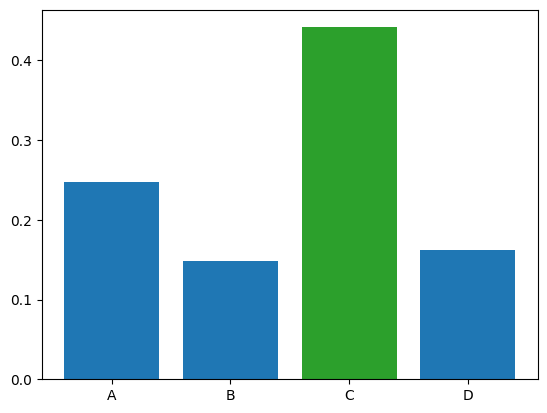
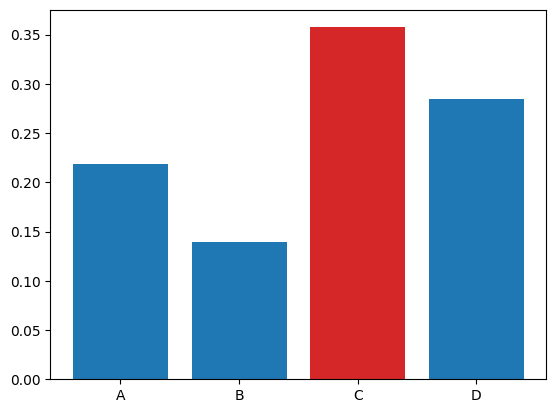

In [18]:
example_question_report(13914)

## Question: How much dietary protein should athletes consume daily?


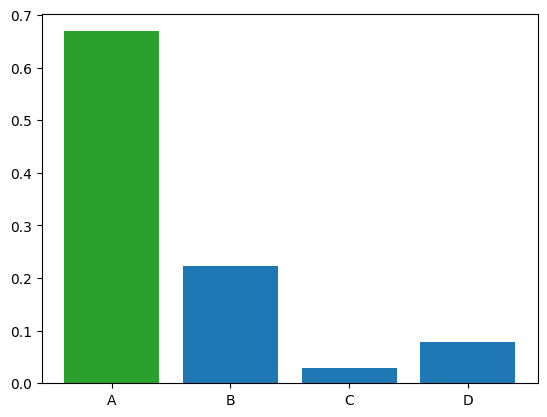
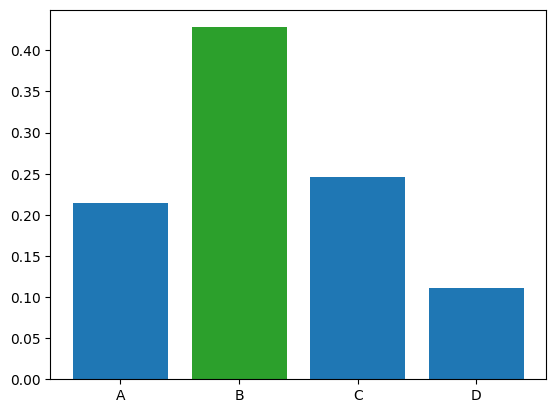
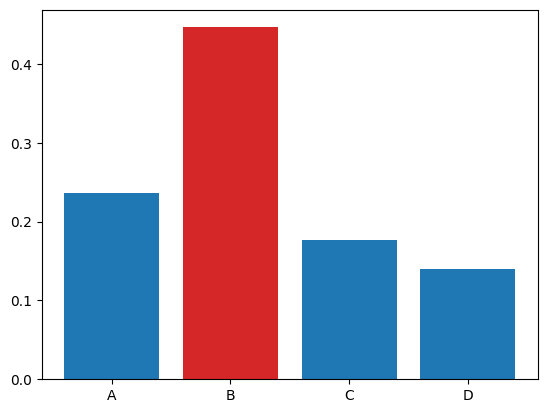
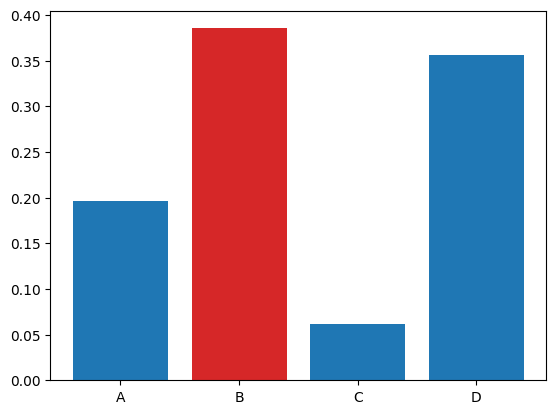

In [19]:
example_question_report(9683)

# Quantifying Order Dependency

Now that we've seen a handful of specific examples, let's step back and try to quantify the extent of the the order dependency problem. We'll follow the same approach used by Zheng et al. (2024) where we record the model's accuracy across 5 segments: U, A, B, C, D. The U segment is the initial "uniform" segment where the answers are evenly distributed across all 4 options. The A, B, C, and D segments represent scenarios where the correct answers are all shifted to one option.

The idea is that if we move the correct answers to option A and the model's accuracy improves relative to the uniform scenario, then this suggests the model favors option A. Conversely, if we move the correct answers to option B and the model's accuracy gets worse, then this suggests the model is avoiding option B. By repeating this process over multiple random samples of questions, we can test the consistency of the model's behavior.

In [20]:
%%time

# Sanity checks

# n_questions must be multiple of 4
assert n_questions % 4 == 0

# Summary
print(f"Running experiment: {n_runs} runs w/ {n_questions}-question samples taken from population of {len(questions)} questions.")

# Reset results
raw_results = []

# Repeat over multiple runs
for run in range(n_runs):

    # Reset results
    metrics = {}
    
    # Randomly select question sample
    selected_questions = sample(questions, n_questions)
    
    # Debias questions
    selected_questions = llb.mmlu.debias_question_answers(selected_questions)

    # Verify selected questions are uniformly distributed
    distribution = llb.mmlu.answer_distribution(selected_questions)
    assert len(set(distribution.values())) == 1

    # Iterate through each segment
    for segment in ["U", "A", "B", "C", "D"]:
        segment_questions = selected_questions
    
        # If segment is A, B, C, D swap the answers to the target option
        if segment in OPTIONS:
            segment_questions = llb.mmlu.swap_answers(segment_questions, segment)
    
        # Answer each question
        start_time = timer()
        answers = tuple(a for a in tqdm(generator(segment_questions), total=n_questions, desc=segment))
        duration = timer() - start_time
        
        # Record performance metrics
        correct = sum(1 for a in answers if a.correct)
        accuracy = correct / n_questions
        rps = 1000000000 * n_questions / duration
        
        metrics[segment] = {
            "questions": segment_questions,
            "answers": answers,
            "n": n_questions,
            "correct": correct,
            "accuracy": accuracy,
            "rps": rps,
        }
    
    raw_results.append(metrics)
    print(f"Completed run {run}")

Running experiment: 10 runs w/ 256-question samples taken from population of 12963 questions.


D: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.50it/s]


Completed run 0


D: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:47<00:00,  5.34it/s]


Completed run 1


D: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:46<00:00,  5.50it/s]


Completed run 2


D: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:45<00:00,  5.68it/s]


Completed run 3


D: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:47<00:00,  5.34it/s]


Completed run 4


D: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:48<00:00,  5.22it/s]


Completed run 5


D: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:45<00:00,  5.64it/s]


Completed run 6


D: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:44<00:00,  5.71it/s]


Completed run 7


D: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:48<00:00,  5.28it/s]


Completed run 8


D: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:43<00:00,  5.92it/s]

Completed run 9
CPU times: user 16min 28s, sys: 3min 2s, total: 19min 30s
Wall time: 39min 24s


## Analysis

In [21]:
# Post-process raw results
rows = []
for run in raw_results:
    baseline = run["U"]["accuracy"]
    for segment in ["U", "A", "B", "C", "D"]:
        rows.append({
            "segment": segment,
            "accuracy": run[segment]["accuracy"],
            "accuracy_delta": run[segment]["accuracy"] - baseline,
        })
results = DataFrame(rows)

Text(0.5, 1.0, 'Accuracy Delta (runs=10, n=256)')

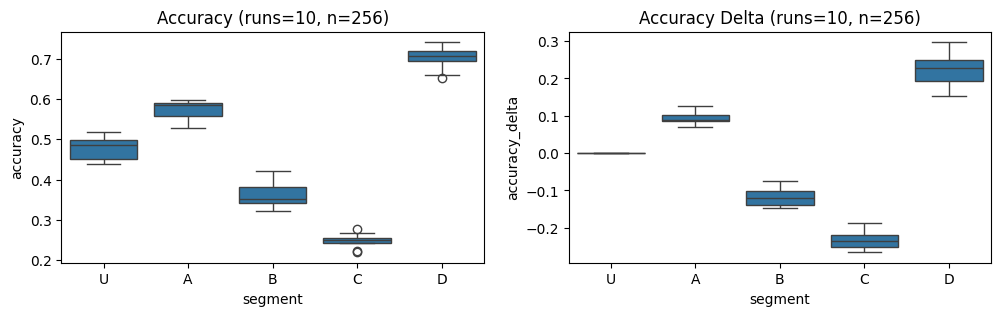

In [22]:
fig, axs = plt.subplots(ncols=2, figsize=(12,3))

# Accuracy
sns.boxplot(x="segment", y="accuracy", data=results, ax=axs[0])
axs[0].set_title(f"Accuracy (runs={n_runs}, n={n_questions})")

# Accuracy Delta
sns.boxplot(x="segment", y="accuracy_delta", data=results, ax=axs[1])
axs[1].set_title(f"Accuracy Delta (runs={n_runs}, n={n_questions})")

Here we see a strong pattern of consistent model behavior. The model exhibits a slight preference for option A, a slight aversion to option B, a strong aversion to option C, and a strong preference for option D.

Now that we've discovered the pattern, let's try to put it into practice by taking a question the model initially got wrong and trying to "coach" the model by moving the correct answer to option A or D.

After a little bit of digging through the wrong answers, I came across question 4481. This is a great example because the model isn't confident about any of the options. The original version was Scenario B, which the model got wrong. But if we move the correct answer to either A or D, then the model get its right.


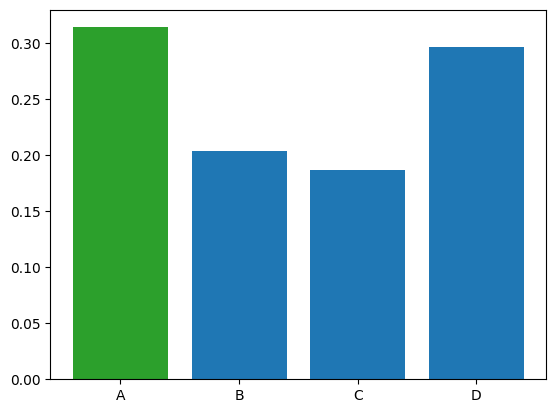
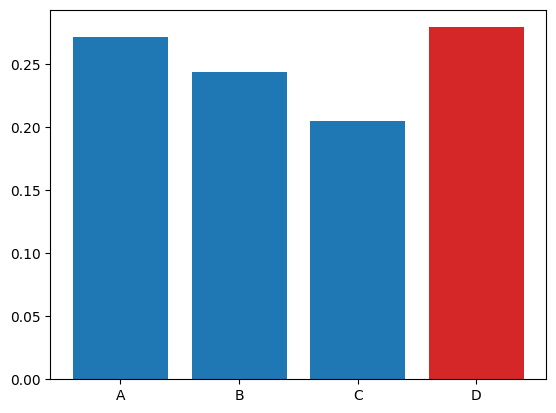
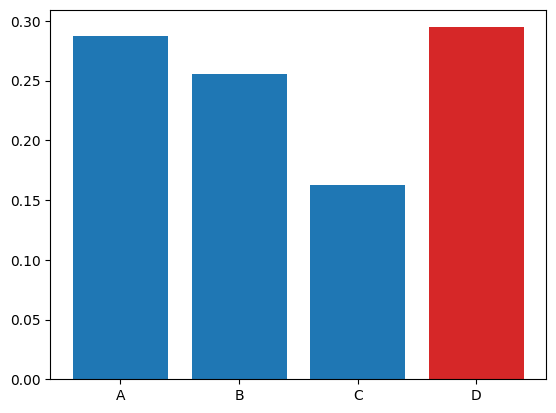
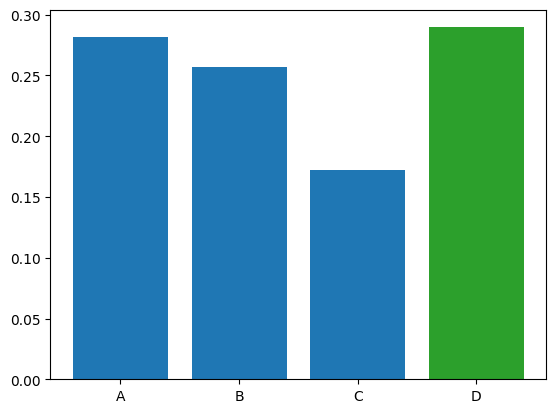

In [23]:
example_question_report(4481)

# Exploring Potential Order Dependency Causes

So why does the LLM prefer one option over another? Pezeshkpour and Hruschka (2023) suggest the issue is caused by a combination of uncertainty and *positional bias*. Questions 7779 and 4481 provide great examples of low and high uncertainty respectively. The model is so confident about its answer to 7779, it doesn't matter where we move it. In contrast, the model has no idea how to answer 4481. All 4 options are practically tied. What's a model to do?

Pezeshkpour and Hruschka (2023) investigated patterns in *positional bias*. The idea is the model falls back on simple heuristics like "when in doubt, choose the last one". What's interesting is even though they were studying completely different LLMs (GPT4 and InstructGPT), the main pattern that emerged is eerily similar to what we saw in the last section.

> We found that for amplifying bias, the optimal strategy involves positioning the top two choices as the first and last options. (Pezeshkpour and Hruschka 2023)

Zheng et al. (2024) have a different hypothesis. Instead of preferring answers based on their position (first, last, etc), Zheng et al. (2024) suggest the model is actually biased by specific option ID tokens (e.g. A, B, C, D).

## Position Bias vs. Token Bias

Let's see if we can test this idea. Let's repeat the Quantifying Order Dependency experiment with a few small changes. We'll prepend the option names to the original option values and then change the prompt generator to leave out the option names. If we leave everything else the same, what should happen is the option ids A, B, C, D will move up and down the list with the original values. If the underlying issue is really about positional bias, then we should see the same pattern as before. If the underlying issue is one of token bias, then we should see less difference between the segments.

In [24]:
# Prepend the option names to original values
updated_questions = []
for q in questions:
    data = q._asdict()
    for option in OPTIONS:
        data[option] = f"{option}) {data[option]}"
    updated_questions.append(Question(**data))
questions = tuple(updated_questions)

Next, let's replace the `llb.mmlu.generate_prompt` function with one that leaves off the option prefix.

In [25]:
def generate_prompt(question: Question):
    """Generate prompt for specified question."""

    # Pose question
    content = (
        f"Question: {question.question}\n"
        f"\n"
        f"{question.A}\n"
        f"{question.B}\n"
        f"{question.C}\n"
        f"{question.D}\n"
        f"\n"
        f"Answer: "
    )

    return content

# Replace function in the library
llb.mmlu.generate_prompt = generate_prompt

Now, let's try it out. The report below is for the same question 4481 from the last section. Note that the option prefixes move along with the content now.


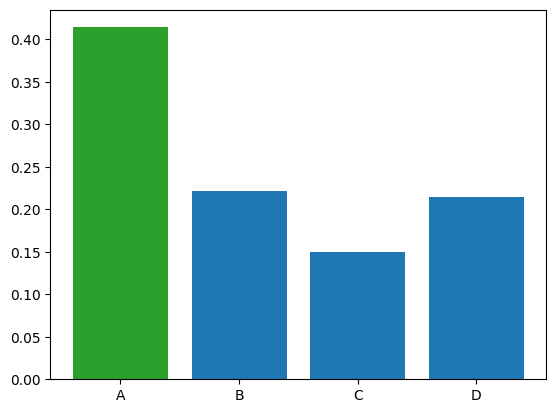
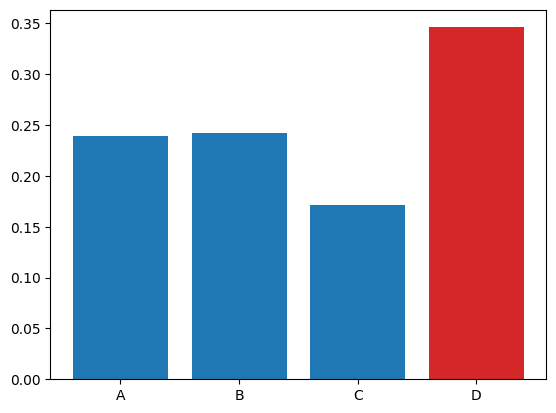
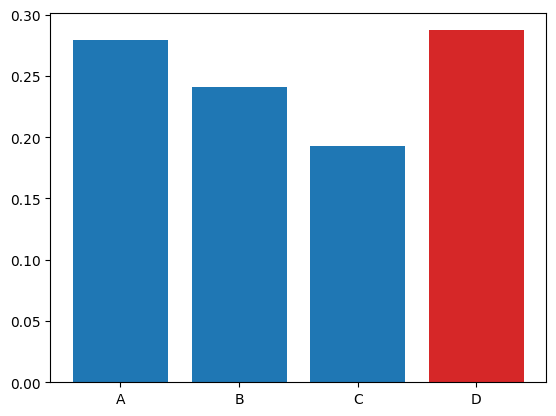
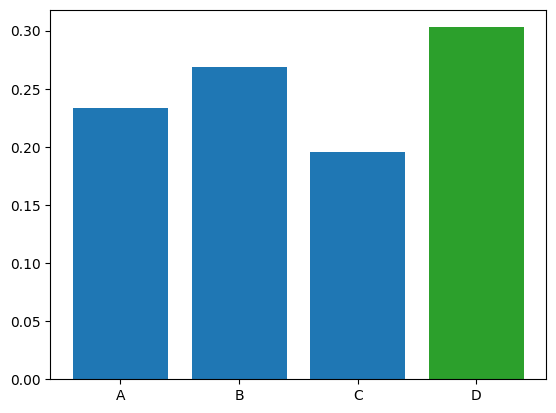

In [26]:
example_question_report(4481)

A quick comparison of the first 4481 report with this one does show some changes in the model's confidence. This may support the *token bias* hypothesis from Zheng et al. (2024). But we need to step back and measure the effects at scale again.

In [27]:
%%time

# Sanity checks

# n_questions must be multiple of 4
assert n_questions % 4 == 0

# Summary
print(f"Running experiment: {n_runs} runs w/ {n_questions}-question samples taken from population of {len(questions)} questions.")

# Reset results
raw_results = []

# Repeat over multiple runs
for run in range(n_runs):

    # Reset results
    metrics = {}
    
    # Randomly select question sample
    selected_questions = sample(questions, n_questions)
    
    # Debias questions
    selected_questions = llb.mmlu.debias_question_answers(selected_questions)

    # Verify selected questions are uniformly distributed
    distribution = llb.mmlu.answer_distribution(selected_questions)
    assert len(set(distribution.values())) == 1

    # Iterate through each segment
    for segment in ["U", "A", "B", "C", "D"]:
        segment_questions = selected_questions
    
        # If segment is A, B, C, D swap the answers to the target option
        if segment in OPTIONS:
            segment_questions = llb.mmlu.swap_answers(segment_questions, segment)
    
        # Answer each question
        start_time = timer()
        answers = tuple(a for a in tqdm(generator(segment_questions), total=n_questions, desc=segment))
        duration = timer() - start_time
        
        # Record performance metrics
        correct = sum(1 for a in answers if a.correct)
        accuracy = correct / n_questions
        rps = 1000000000 * n_questions / duration
        
        metrics[segment] = {
            "questions": segment_questions,
            "answers": answers,
            "n": n_questions,
            "correct": correct,
            "accuracy": accuracy,
            "rps": rps,
        }
    
    raw_results.append(metrics)
    print(f"Completed run {run}")

Running experiment: 10 runs w/ 256-question samples taken from population of 12963 questions.


D: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:45<00:00,  5.68it/s]


Completed run 0


D: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:47<00:00,  5.34it/s]


Completed run 1


D: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:47<00:00,  5.37it/s]


Completed run 2


D: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:48<00:00,  5.26it/s]


Completed run 3


D: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:45<00:00,  5.66it/s]


Completed run 4


D: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:48<00:00,  5.30it/s]


Completed run 5


D: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:45<00:00,  5.65it/s]


Completed run 6


D: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:47<00:00,  5.41it/s]


Completed run 7


D: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:48<00:00,  5.26it/s]


Completed run 8


D: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:49<00:00,  5.19it/s]

Completed run 9
CPU times: user 16min 4s, sys: 3min 3s, total: 19min 8s
Wall time: 39min 34s


In [28]:
# Post-process raw results
rows = []
for run in raw_results:
    baseline = run["U"]["accuracy"]
    for segment in ["U", "A", "B", "C", "D"]:
        rows.append({
            "segment": segment,
            "accuracy": run[segment]["accuracy"],
            "accuracy_delta": run[segment]["accuracy"] - baseline,
        })
results = DataFrame(rows)

Text(0.5, 1.0, 'Accuracy Delta (runs=10, n=256)')

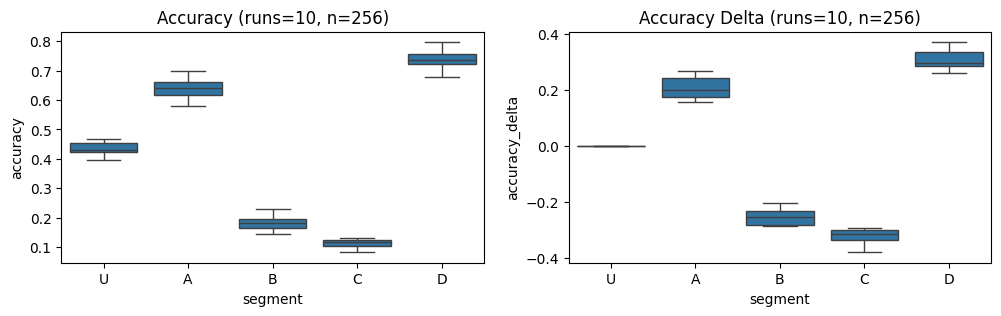

In [29]:
fig, axs = plt.subplots(ncols=2, figsize=(12,3))

# Accuracy
sns.boxplot(x="segment", y="accuracy", data=results, ax=axs[0])
axs[0].set_title(f"Accuracy (runs={n_runs}, n={n_questions})")

# Accuracy Delta
sns.boxplot(x="segment", y="accuracy_delta", data=results, ax=axs[1])
axs[1].set_title(f"Accuracy Delta (runs={n_runs}, n={n_questions})")

Interesting! The pattern is almost identical to the first experiment. This would suggest that it's the positions that matter more than the option labels. Definitely seems worth investigating further in future experiments!

# Summary

Using Meta's latest state-of-the-art Llama 3.2 3B LLM, we were able to clearly show consistent order dependency effects. We looked at a handful of individual examples up close and then zoomed out to estimate the extent of the issue in general. Finally, we ran a modified version of the experiment that seemed to lend support to Pezeshkpour and Hruschka (2023)'s *positional bias* hypothesis over the *token bias* hypothesis from Zheng et al. (2024).

# References

Almazrouei, Ebtesam, Hamza Alobeidli, Abdulaziz Alshamsi, Alessandro Cappelli, Ruxandra Cojocaru, Mérouane Debbah, Étienne Goffinet, et al. 2023. “The Falcon Series of Open Language Models.” arXiv. https://doi.org/10.48550/arXiv.2311.16867.

Dubey, Abhimanyu, Abhinav Jauhri, Abhinav Pandey, Abhishek Kadian, Ahmad Al-Dahle, Aiesha Letman, Akhil Mathur, et al. 2024. “The Llama 3 Herd of Models.” arXiv.Org. July 31, 2024. https://arxiv.org/abs/2407.21783v2.

Hendrycks, Dan, Collin Burns, Steven Basart, Andy Zou, Mantas Mazeika, Dawn Song, and Jacob Steinhardt. 2021. “Measuring Massive Multitask Language Understanding.” arXiv. https://doi.org/10.48550/arXiv.2009.03300.

Liusie, Adian, Potsawee Manakul, and Mark J. F. Gales. 2024. “LLM Comparative Assessment: Zero-Shot NLG Evaluation through Pairwise Comparisons Using Large Language Models.” arXiv. https://doi.org/10.48550/arXiv.2307.07889.

McIlroy-Young, Reid, Katrina Brown, Conlan Olson, Linjun Zhang, and Cynthia Dwork. 2024. “Set-Based Prompting: Provably Solving the Language Model Order Dependency Problem.” arXiv. https://doi.org/10.48550/arXiv.2406.06581.

OpenAI, Josh Achiam, Steven Adler, Sandhini Agarwal, Lama Ahmad, Ilge Akkaya, Florencia Leoni Aleman, et al. 2024. “GPT-4 Technical Report.” arXiv. https://doi.org/10.48550/arXiv.2303.08774.

Ouyang, Long, Jeff Wu, Xu Jiang, Diogo Almeida, Carroll L. Wainwright, Pamela Mishkin, Chong Zhang, et al. 2022. “Training Language Models to Follow Instructions with Human Feedback.” arXiv. https://doi.org/10.48550/arXiv.2203.02155.

Pezeshkpour, Pouya, and Estevam Hruschka. 2023. “Large Language Models Sensitivity to The Order of Options in Multiple-Choice Questions.” arXiv. https://doi.org/10.48550/arXiv.2308.11483.

“Vicuna: An Open-Source Chatbot Impressing GPT-4 with 90%* ChatGPT Quality | LMSYS Org.” n.d. Accessed November 7, 2024. https://lmsys.org/blog/2023-03-30-vicuna.

Zheng, Chujie, Hao Zhou, Fandong Meng, Jie Zhou, and Minlie Huang. 2024. “Large Language Models Are Not Robust Multiple Choice Selectors.” arXiv. https://doi.org/10.48550/arXiv.2309.03882.